In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use('ggplot')


In [84]:
df= pd.read_pickle('EURUSD_2020-2023_15M.bz2')

In [85]:
df

,open,high,low,close
time,,,,
2020-01-02 00:00:00,1.12118,1.12118,1.12073,1.12073
2020-01-02 00:15:00,1.12073,1.12152,1.12073,1.12144
2020-01-02 00:30:00,1.12145,1.12157,1.12141,1.12151
2020-01-02 00:45:00,1.12156,1.12165,1.12142,1.12142
2020-01-02 01:00:00,1.12142,1.12216,1.12142,1.12201
...,...,...,...,...
2023-11-28 14:15:00,1.09586,1.09623,1.09525,1.09536
2023-11-28 14:30:00,1.09536,1.09581,1.09519,1.09562
2023-11-28 14:45:00,1.09561,1.09564,1.09472,1.09505


# Backtest Engine
This is basic event based backtest. There is a lot of space to improve. 
Cumulative profit and drawdown is calculate just from close. Heat during the open trade could brings real bigger drowdown.

In [86]:
class BacktestEngine:
    def __init__(self, df, params):
        self.df = df.copy()
        self.trades = pd.DataFrame(columns=["Open Time", "Close Time", "Type", "Open Price", "Close Price", "Profit", "Cumulative Profit"])
        self.cumulative_profit = 0
        self.open_trade = None  
        self.pip_cost = params['pip_cost']  


    def execute_trade(self, open_bar, close_bar, trade_type):
        open_price = self.df.iloc[open_bar]["close"]
        close_price = self.df.iloc[close_bar]["close"]
        
        if trade_type == "long":
            profit = close_price - open_price - self.pip_cost
        else:  # trade_type == "short"
            profit = open_price - close_price - self.pip_cost
        
        self.cumulative_profit += profit

        new_trade = pd.DataFrame({
            "Open Time": [self.df.index[open_bar]],
            "Close Time": [self.df.index[close_bar]],
            "Type": [trade_type],
            "Open Price": [open_price],
            "Close Price": [close_price],
            "Profit": [profit],
            "Cost": [self.pip_cost],
            "Cumulative Profit": [self.cumulative_profit]
        })

        self.trades = pd.concat([self.trades, new_trade], ignore_index=True)


    def plot_trades_on_price(self, ax):
        ax.plot(self.df.index, self.df['close'], label='Close Price', color='blue')
        for _, trade in self.trades.iterrows():
            color = 'green' if trade['Type'] == 'long' else 'red'
            ax.scatter(trade['Open Time'], trade['Open Price'], marker='o', color=color)
            ax.scatter(trade['Close Time'], trade['Close Price'], marker='x', color=color)
            ax.plot([trade['Open Time'], trade['Close Time']], [trade['Open Price'], trade['Close Price']], color=color)
        ax.set_ylabel('Price')
        ax.legend()

    def calculate_cumulative_profit_and_drawdown(self):
        self.df['cumulative_profit'] = 0
        max_cumulative_profit = 0
        for _, trade in self.trades.iterrows():
            self.df.loc[self.df.index >= trade['Open Time'], 'cumulative_profit'] += trade['Profit']
            max_cumulative_profit = max(max_cumulative_profit, self.df.loc[trade['Open Time'], 'cumulative_profit'])
            self.df.loc[self.df.index >= trade['Open Time'], 'max_cumulative_profit'] = max_cumulative_profit

        self.df['drawdown'] = self.df['max_cumulative_profit'] - self.df['cumulative_profit']

    def plot_performance(self):
        self.calculate_cumulative_profit_and_drawdown()

        plt.figure(figsize=(15, 12))
        gs = gridspec.GridSpec(4, 1)

        ax1 = plt.subplot(gs[:2, 0])
        self.plot_trades_on_price(ax1)
        ax1.set_title('Backtest Result with Trades')

        ax2 = plt.subplot(gs[2, 0], sharex=ax1)
        ax2.plot(self.df.index, self.df['cumulative_profit'], label='Cumulative Profit', color='blue')
        ax2.set_ylabel('Cumulative Profit')
        ax2.legend()

        ax3 = plt.subplot(gs[3, 0], sharex=ax1)
        inverse_drawdown = -self.df['drawdown']
        ax3.fill_between(self.df.index, inverse_drawdown, 0, color='red', alpha=0.3)
        ax3.plot(self.df.index, inverse_drawdown, label='Inverse Drawdown', color='red')
        ax3.set_ylabel('Inverse Drawdown')
        ax3.set_xlabel('Time')
        ax3.legend()

        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)

        plt.tight_layout()
        plt.show()


In [87]:
class RSIStrategy(BacktestEngine):
    def __init__(self, df,params):
        super().__init__(df,params)
        self.calculate_rsi()

    def calculate_rsi(self, periods=14):
        delta = self.df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()

        rs = gain / loss
        self.df['rsi'] = 100 - (100 / (1 + rs))

    def apply_strategy(self):
        for i in range(1, len(self.df)):
            if self.open_trade is None:
                if self.df.iloc[i]['rsi'] < 30:
                    self.open_trade = ("long", i)
                elif self.df.iloc[i]['rsi'] > 70:
                    self.open_trade = ("short", i)
            else:
                trade_type, open_bar = self.open_trade
                if (trade_type == "long" and self.df.iloc[i]['rsi'] >= 50) or (trade_type == "short" and self.df.iloc[i]['rsi'] <= 50):
                    self.execute_trade(open_bar, i, trade_type)
                    self.open_trade = None


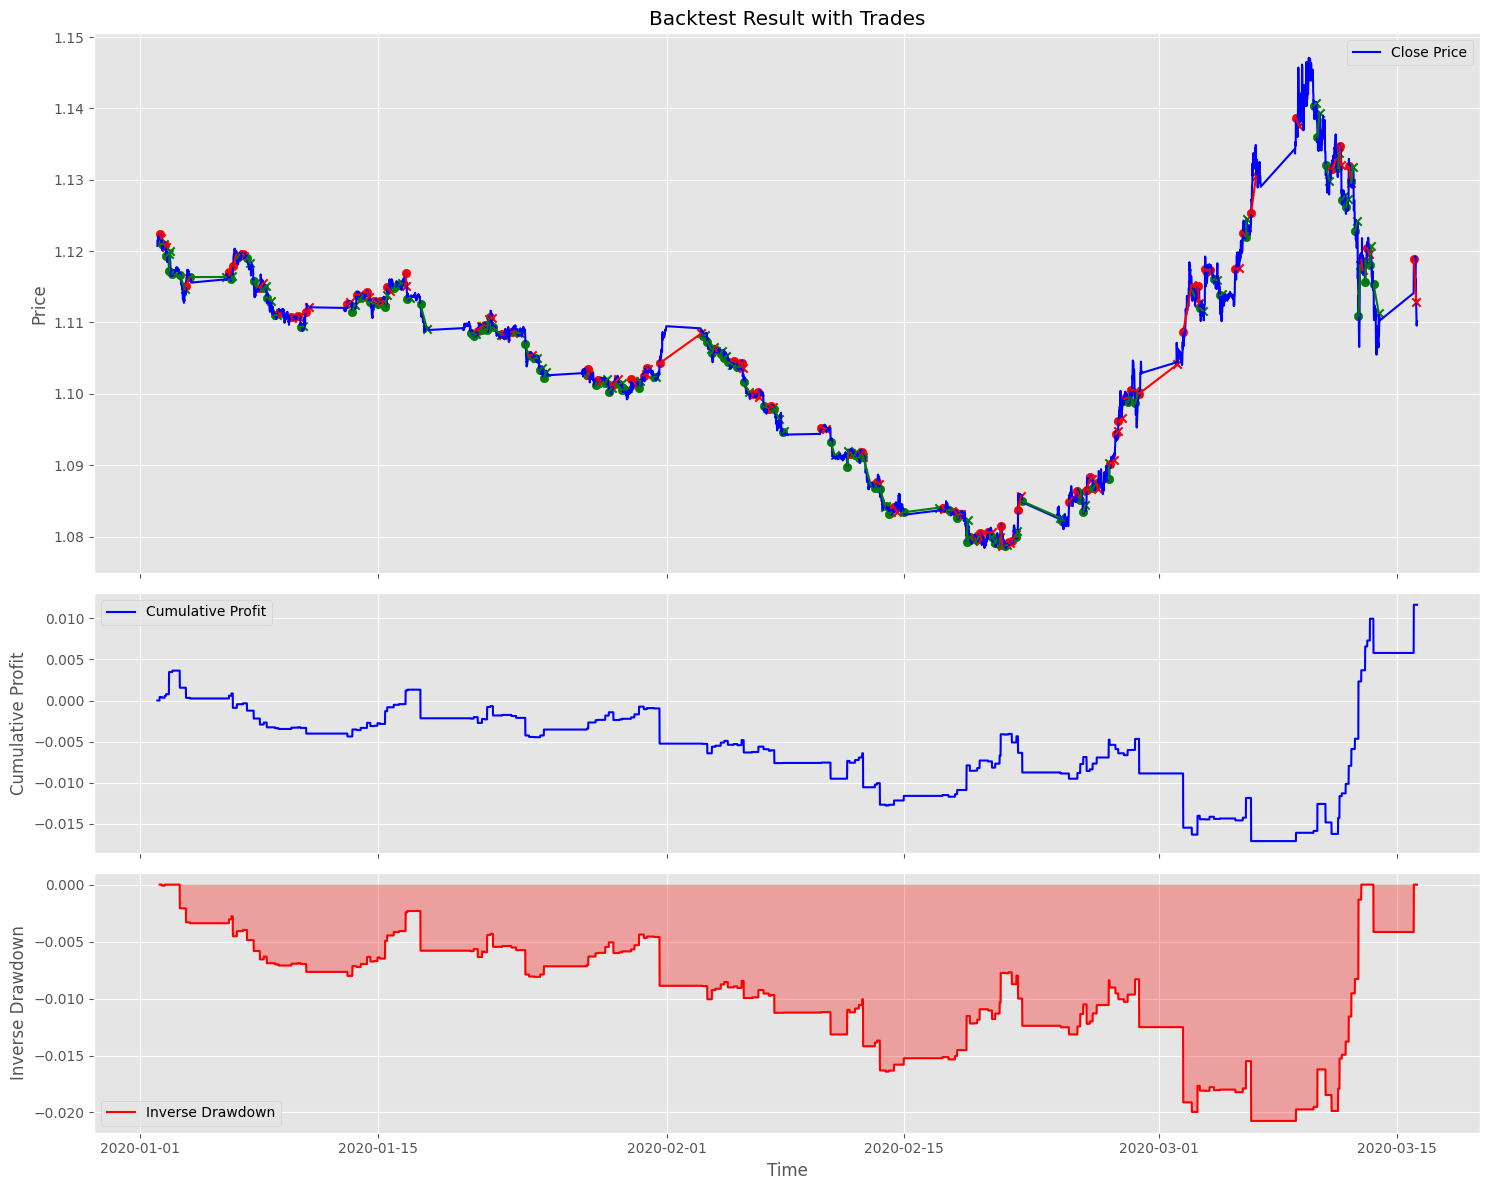

In [88]:
params = {
    "pip_cost": 0.0001
}

strategy = RSIStrategy(df[:5000], params)
strategy.apply_strategy()
strategy.plot_performance()
